In this simple exploration notebook, let us try and explore the dataset given for this competition.

**Update on 25 May 2017: Since there are a couple of leaky features now, let us explore the same as well in the notebook** 

**Objective:**

To classify whether question pairs are duplicate or not. 

Let us start with importing the necessary modules for exploring the data.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk import word_tokenize, ngrams
from sklearn import ensemble
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
import xgboost as xgb

eng_stopwords = set(stopwords.words('english'))
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'

Let us read both the train and test dataset and check the number of rows.

In [2]:
train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv")
print(train_df.shape)
print(test_df.shape)

(404290, 6)
(2345796, 3)


Okay. So there are about 400K rows in train set and about 2.35M rows in test set.

Also there are 6 columns in train set but only 3 of them are in test set. So we shall first look at the top few lines to understand the columns that are missing in the test set.

In [3]:
train_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


**Data fields**

id - the id of a training set question pair

qid1, qid2 - unique ids of each question (only available in train.csv)

question1, question2 - the full text of each question

is_duplicate - the target variable, set to 1 if question1 and question2 have essentially the same meaning, and 0 otherwise.

In [4]:
test_df.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


So we do not have question ids for the test set. I hope the reason is as follows:

*As an anti-cheating measure, Kaggle has supplemented the test set with computer-generated question pairs. Those rows do not come from Quora, and are not counted in the scoring. All of the questions in the training set are genuine examples from Quora.*

Since some questions are not from Quora, question ids are not present I think.

**Target Variable Exploration:**

First let us look at the target variable distribution.

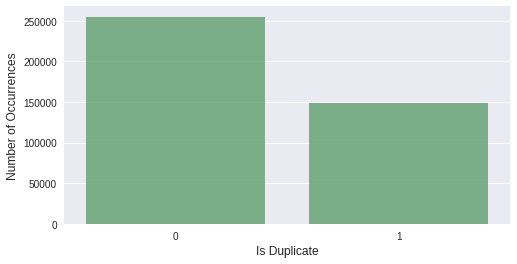

In [5]:
is_dup = train_df['is_duplicate'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(is_dup.index, is_dup.values, alpha=0.8, color=color[1])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Is Duplicate', fontsize=12)
plt.show()

In [6]:
is_dup / is_dup.sum()

0    0.630802
1    0.369198
Name: is_duplicate, dtype: float64

So we have about 63% non-duplicate questions and 37% duplicate questions in the training data set.

**Questions Exploration:**

Now let us explore the question fields present in the train data. First let us check the number of words distribution in the questions.

In [7]:
all_ques_df = pd.DataFrame(pd.concat([train_df['question1'], train_df['question2']]))
all_ques_df.columns = ["questions"]

all_ques_df["num_of_words"] = all_ques_df["questions"].apply(lambda x : len(str(x).split()))

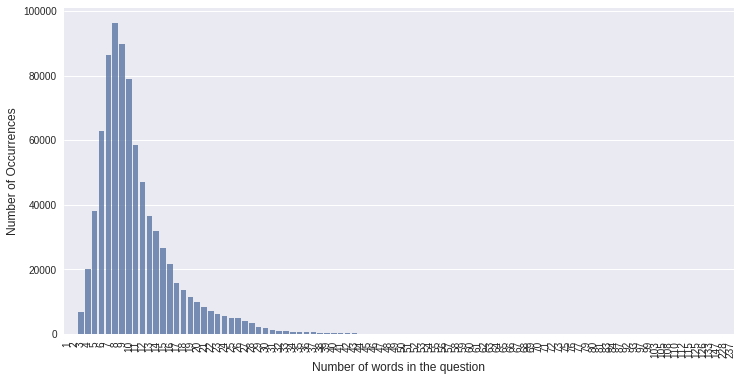

In [8]:
cnt_srs = all_ques_df['num_of_words'].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[0])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of words in the question', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

So the distribution is right skewed with upto 237 words in a question. There are also few questions with 1 or 2 words as well.

Now let us explore the number of characters distribution as well.

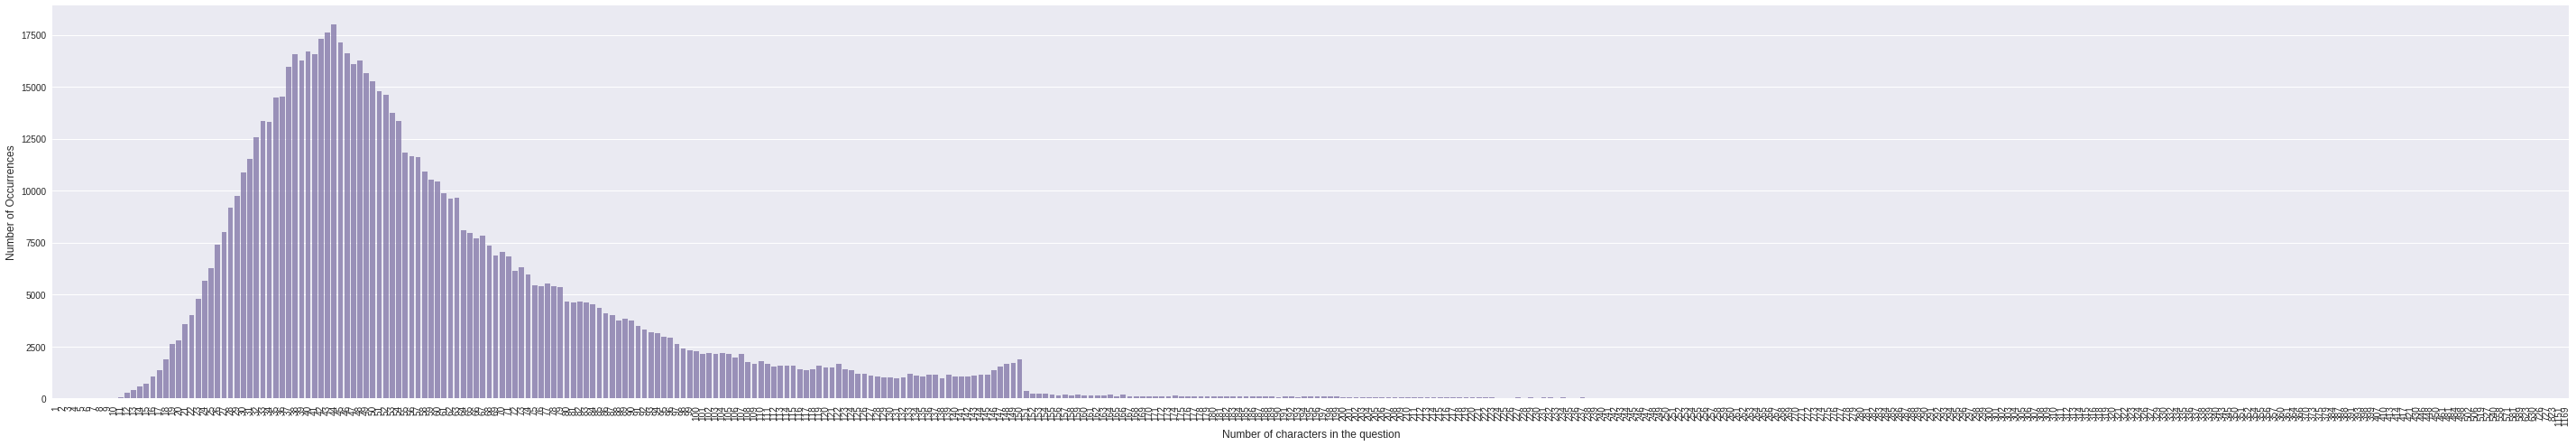

In [9]:
all_ques_df["num_of_chars"] = all_ques_df["questions"].apply(lambda x : len(str(x)))
cnt_srs = all_ques_df['num_of_chars'].value_counts()

plt.figure(figsize=(50,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[3])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of characters in the question', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()      

del all_ques_df

Number of characters distribution as well is right skewed.

One interesting point is the sudden dip at the 150 character mark. Not sure why is that so.!

Now let us look at the distribution of common unigrams between the given question pairs.

In [10]:
def get_unigrams(que):
    return [word for word in word_tokenize(que.lower()) if word not in eng_stopwords]

def get_common_unigrams(row):
    return len( set(row["unigrams_ques1"]).intersection(set(row["unigrams_ques2"])) )

def get_common_unigram_ratio(row):
    return float(row["unigrams_common_count"]) / max(len( set(row["unigrams_ques1"]).union(set(row["unigrams_ques2"])) ),1)

train_df["unigrams_ques1"] = train_df['question1'].apply(lambda x: get_unigrams(str(x)))
train_df["unigrams_ques2"] = train_df['question2'].apply(lambda x: get_unigrams(str(x)))
train_df["unigrams_common_count"] = train_df.apply(lambda row: get_common_unigrams(row),axis=1)
train_df["unigrams_common_ratio"] = train_df.apply(lambda row: get_common_unigram_ratio(row), axis=1)

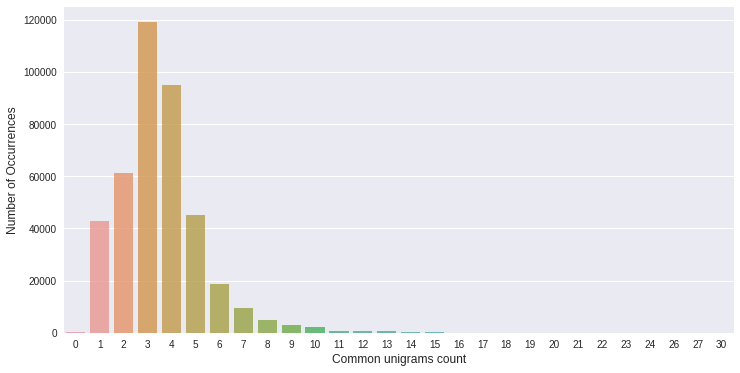

In [11]:
cnt_srs = train_df['unigrams_common_count'].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Common unigrams count', fontsize=12)
plt.show()

It is interesting to see that there are very few question pairs with no common words. 

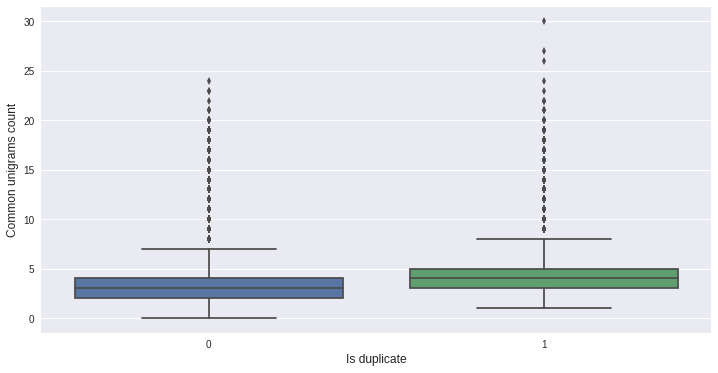

In [12]:
plt.figure(figsize=(12,6))
sns.boxplot(x="is_duplicate", y="unigrams_common_count", data=train_df)
plt.xlabel('Is duplicate', fontsize=12)
plt.ylabel('Common unigrams count', fontsize=12)
plt.show()

There is some good difference between 0 and 1 class using the common unigram count variable. Let us look at the same graph using common unigrams ratio.

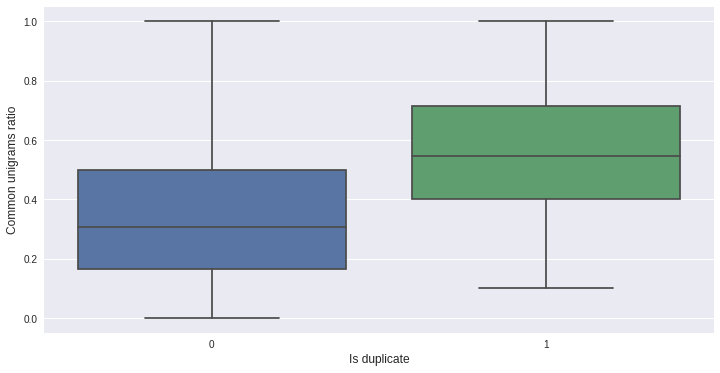

In [13]:
plt.figure(figsize=(12,6))
sns.boxplot(x="is_duplicate", y="unigrams_common_ratio", data=train_df)
plt.xlabel('Is duplicate', fontsize=12)
plt.ylabel('Common unigrams ratio', fontsize=12)
plt.show()

**Leaky Features Exploration:**

Now let us get into the leaky data exploration part. We have a couple of leaky features which seem to improve the score significantly. 

 1. [Frequency based feature by Jared Turkewitz][1]
 2. [Intersection of common neighbors by Krzysztof Dziedzic implemented by tour1st][2]


  [1]: https://www.kaggle.com/jturkewitz/magic-features-0-03-gain
  [2]: https://www.kaggle.com/tour1st/magic-feature-v2-0-045-gain

In [14]:
ques = pd.concat([train_df[['question1', 'question2']], \
        test_df[['question1', 'question2']]], axis=0).reset_index(drop='index')
ques.shape

(2750086, 2)

In [15]:
from collections import defaultdict
q_dict = defaultdict(set)
for i in range(ques.shape[0]):
        q_dict[ques.question1[i]].add(ques.question2[i])
        q_dict[ques.question2[i]].add(ques.question1[i])

In [16]:
def q1_freq(row):
    return(len(q_dict[row['question1']]))
    
def q2_freq(row):
    return(len(q_dict[row['question2']]))
    
def q1_q2_intersect(row):
    return(len(set(q_dict[row['question1']]).intersection(set(q_dict[row['question2']]))))

train_df['q1_q2_intersect'] = train_df.apply(q1_q2_intersect, axis=1, raw=True)
train_df['q1_freq'] = train_df.apply(q1_freq, axis=1, raw=True)
train_df['q2_freq'] = train_df.apply(q2_freq, axis=1, raw=True)

**Q1-Q2 neighbor intersection count:**

Let us first do simple count plots and see the distribution.

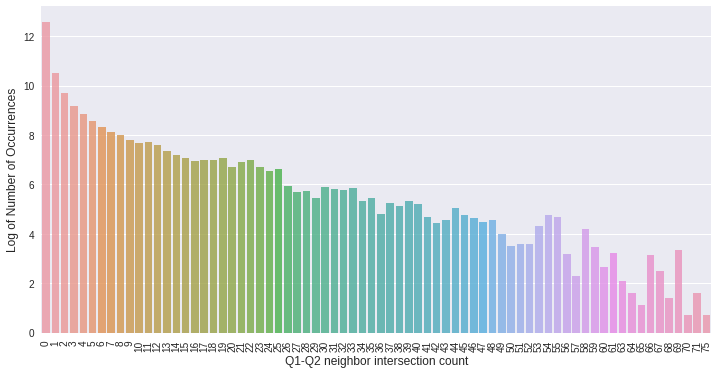

In [17]:
cnt_srs = train_df['q1_q2_intersect'].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, np.log1p(cnt_srs.values), alpha=0.8)
plt.xlabel('Q1-Q2 neighbor intersection count', fontsize=12)
plt.ylabel('Log of Number of Occurrences', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

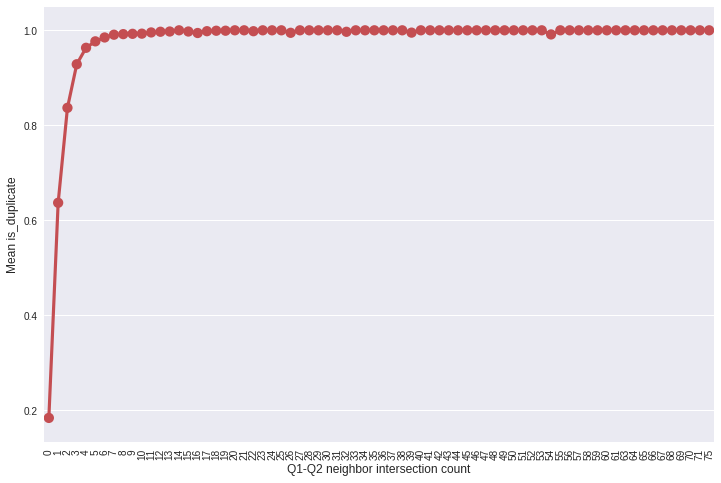

In [18]:
grouped_df = train_df.groupby('q1_q2_intersect')['is_duplicate'].aggregate(np.mean).reset_index()
plt.figure(figsize=(12,8))
sns.pointplot(grouped_df["q1_q2_intersect"].values, grouped_df["is_duplicate"].values, alpha=0.8, color=color[2])
plt.ylabel('Mean is_duplicate', fontsize=12)
plt.xlabel('Q1-Q2 neighbor intersection count', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

Wow. This explains why this variable is super predictive.!

**Question1 Frequency:**

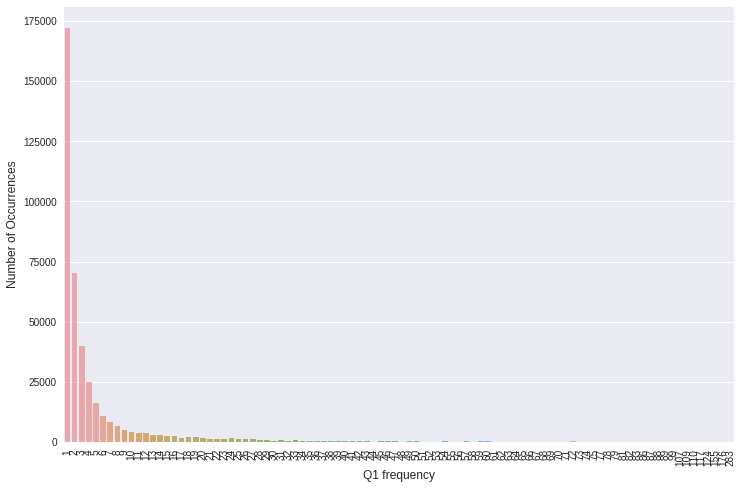

In [19]:
cnt_srs = train_df['q1_freq'].value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.xlabel('Q1 frequency', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

We could see a long tail here as well. Now let us check the target variable distribution.

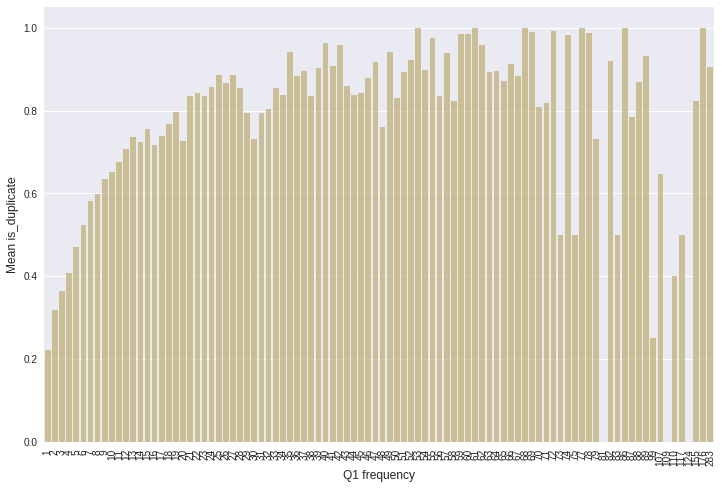

In [20]:
plt.figure(figsize=(12,8))
grouped_df = train_df.groupby('q1_freq')['is_duplicate'].aggregate(np.mean).reset_index()
sns.barplot(grouped_df["q1_freq"].values, grouped_df["is_duplicate"].values, alpha=0.8, color=color[4])
plt.ylabel('Mean is_duplicate', fontsize=12)
plt.xlabel('Q1 frequency', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

Here as well, we can see an increase in the mean target rate as the frequency increases.! Hopefully this is the case with question 2 as well. 

Let us now do a heat map between q1_freq and q2_freq to see the target variable distribution.

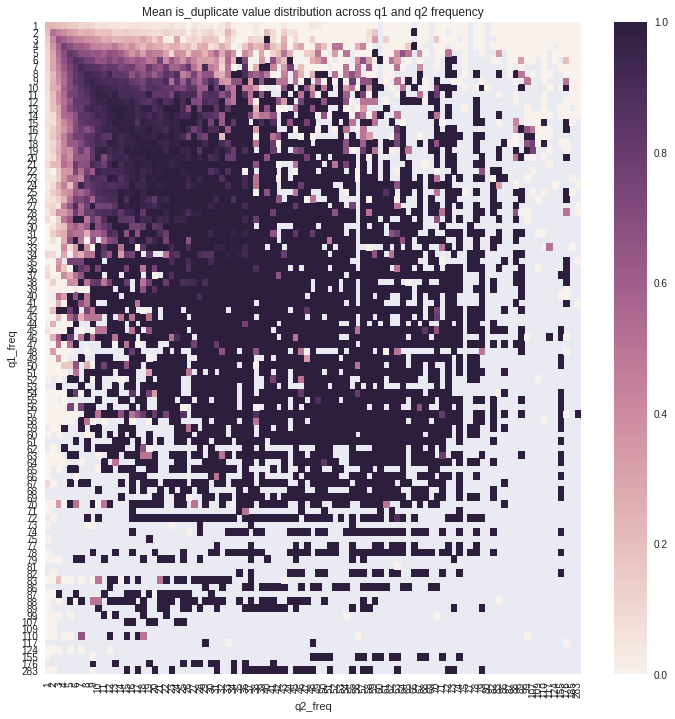

In [21]:
pvt_df = train_df.pivot_table(index="q1_freq", columns="q2_freq", values="is_duplicate")
plt.figure(figsize=(12,12))
sns.heatmap(pvt_df)
plt.title("Mean is_duplicate value distribution across q1 and q2 frequency")
plt.show()

Let us also check the correlation between the three fields.

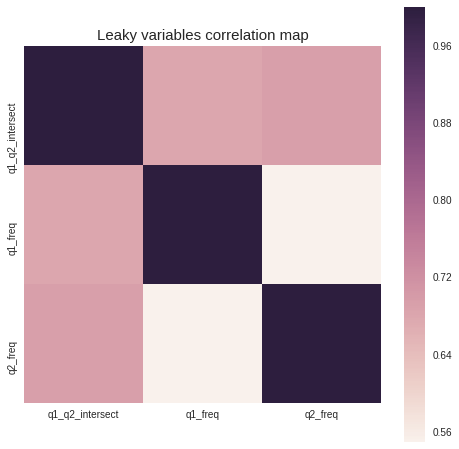

In [22]:
cols_to_use = ['q1_q2_intersect', 'q1_freq', 'q2_freq']
temp_df = train_df[cols_to_use]
corrmat = temp_df.corr(method='spearman')
f, ax = plt.subplots(figsize=(8, 8))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=1., square=True)
plt.title("Leaky variables correlation map", fontsize=15)
plt.show()

Stay tuned.! Yet to complete. Please upvote if you find this useful.!